<a href="https://colab.research.google.com/github/DajanaSanchez/BirdMigrationClimateAnalysis/blob/main/climate_ensemble_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read merged_bird_climate.parquet
import pandas as pd
df = pd.read_parquet('/content/drive/MyDrive/final_merged_dataset.parquet')

In [ ]:
df.sample(5)

,Latitude,Longitude,Observation_Date,Year,Region,Land_Cover_Description,Has_Habitat_Change,Temp_celsius,Precip_mm,Month
7148924,49.098510,-122.677810,2022-05-01,2022,Canada,Urban and Built-up,False,12.04,113.9,5
340086,39.478857,-106.733208,2024-10-01,2024,US,Woody Savannas,False,5.26,30.3,10
7352915,36.393971,-93.741574,2005-11-01,2005,US,Deciduous Broadleaf Forest,False,10.72,26.8,11
4846223,41.394476,-82.048891,2020-03-01,2020,US,Savannas,True,5.87,123.0,3
6514200,44.348432,-87.828827,2024-03-01,2024,US,Croplands,False,3.40,59.7,3


In [ ]:
df.describe()

,Latitude,Longitude,Observation_Date,Year,Temp_celsius,Precip_mm,Month
count,7.498836e+06,7.498836e+06,7498836,7.498836e+06,7.498836e+06,7.498836e+06,7.498836e+06
mean,4.238773e+01,-9.358986e+01,2019-06-21 17:59:32.958363136,2.019055e+03,9.935046e+00,8.072112e+01,5.997464e+00
min,1.934370e+01,-1.790633e+02,1974-01-01 00:00:00,1.974000e+03,-2.975000e+01,0.000000e+00,1.000000e+00
25%,3.912949e+01,-1.140327e+02,2017-05-01 00:00:00,2.017000e+03,3.850000e+00,3.600000e+01,3.000000e+00
50%,4.240090e+01,-8.596323e+01,2020-11-01 00:00:00,2.020000e+03,9.941860e+00,6.760000e+01,5.000000e+00
75%,4.621175e+01,-7.676376e+01,2023-01-01 00:00:00,2.023000e+03,1.640000e+01,1.080000e+02,9.000000e+00
max,7.315889e+01,1.792826e+02,2024-12-01 00:00:00,2.024000e+03,3.930000e+01,1.323200e+03,1.200000e+01
std,6.207601e+00,2.055219e+01,NaN,5.087835e+00,8.348045e+00,6.630785e+01,3.617435e+00


In [ ]:
df.dtypes

,0
Latitude,float64
Longitude,float64
Observation_Date,datetime64[ns]
Year,int32
Region,object
Land_Cover_Description,object
Has_Habitat_Change,bool
Temp_celsius,float64
Precip_mm,float64
Month,int32


In [ ]:
df.isnull().sum()

,0
Latitude,0
Longitude,0
Observation_Date,0
Year,0
Region,0
Land_Cover_Description,0
Has_Habitat_Change,0
Temp_celsius,0
Precip_mm,0
Month,0


In [ ]:
#count observations by year
df['Year'].value_counts()

,count
Year,
2024,995050
2023,936632
2022,872848
2021,848212
2020,700603
2019,575234
2018,497120
2017,414467
2016,341738


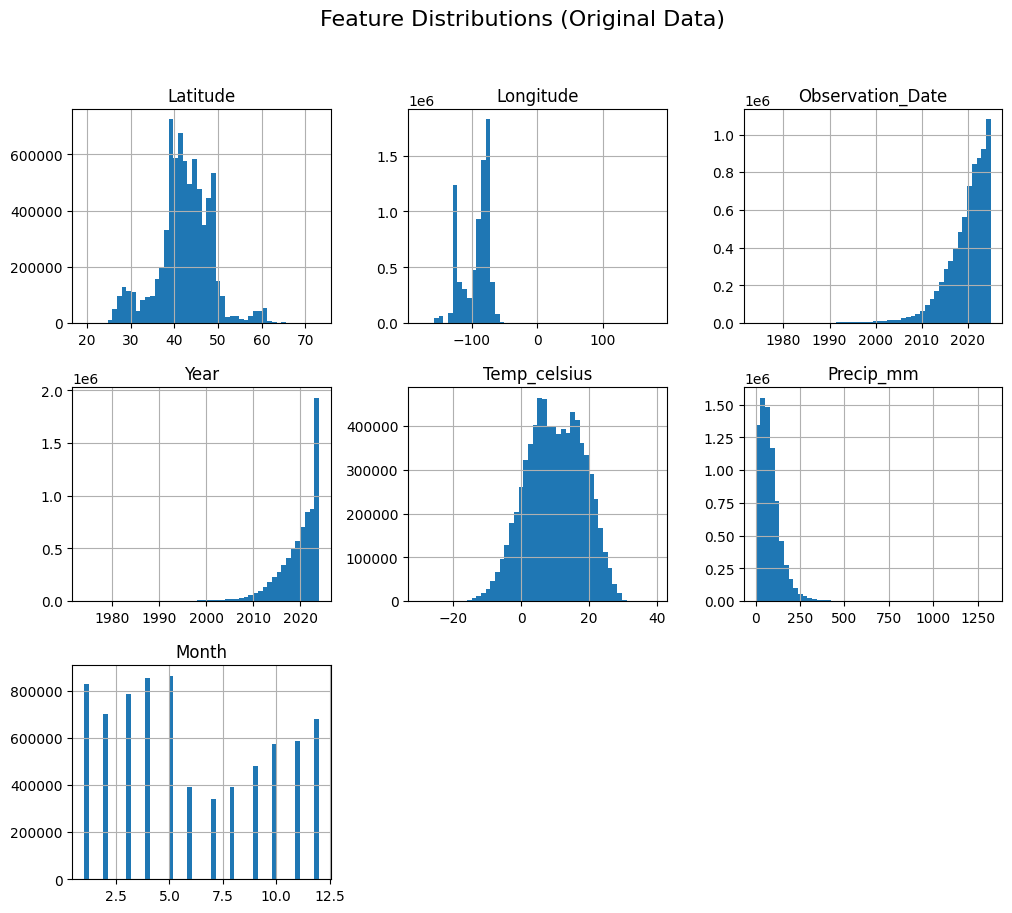

In [ ]:
#plotting variables to see distribution
import matplotlib.pyplot as plt

df.hist(figsize=(12, 10), bins=50)
plt.suptitle("Feature Distributions (Original Data)", fontsize=16)
plt.show()

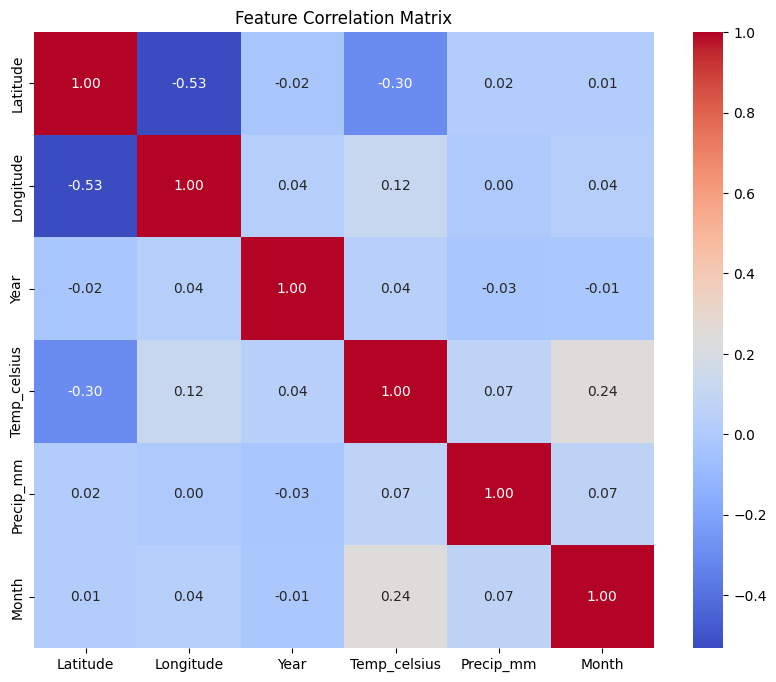

In [ ]:
#feature correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_df = df.select_dtypes(include=["number"])

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


#Assign Sample Weights (Inverse Frequency of Year) to account for imbalance in observations by year**
year_counts = df['Year'].value_counts().to_dict()
df['sample_weight'] = df['Year'].map(lambda y: 1 / year_counts[y])

df["Month"] = df["Month"].astype(int)

# Transformer for Relative Year (Years since first observation)
def relative_year(df):
    """Converts Year to Years Since First Observation."""
    return df[['Year']] - df[['Year']].min()

In [ ]:
# ✅ New Time-Based Train-Test Split (Last 3 Years as Test)
split_years = [2021, 2022, 2023, 2024]
final_test_df = df[df["Year"].isin(split_years)]  # Test set: 2021-2023
train_df = df[~df["Year"].isin(split_years)]  # Train set: Everything else

In [ ]:
from sklearn.utils import resample

# Define threshold year
threshold_year = 2017  # Keep 2017-2020 controlled

# Split training data
latest_years = train_df[train_df["Year"] >= threshold_year]
older_years = train_df[train_df["Year"] < threshold_year]

# **Set Downsampling Targets**
max_mid_recent_size = 275_000   # 2017-2019 target size
min_recent_size = 200_000       # 2020 target size

# **Downsample each recent year separately**
downsampled_recent_years = []
for year in latest_years["Year"].unique():
    subset = latest_years[latest_years["Year"] == year]

    if year in [2017, 2018, 2019]:  # Gradually downsample these years
        n_samples = min(max_mid_recent_size, len(subset))
    elif year == 2020:  # 2020 strict cap
        n_samples = min(min_recent_size, len(subset))
    else:
        n_samples = len(subset)  # Do not modify other years

    downsampled_subset = resample(
        subset,
        replace=False,
        n_samples=n_samples,
        random_state=42
    )
    downsampled_recent_years.append(downsampled_subset)

# **3️⃣ Combine the Balanced Train Data**
train_df_balanced = pd.concat([older_years] + downsampled_recent_years)

# **4️⃣ Verify the New Train-Test Split**
print("Original Training Set Size:", len(train_df))
print("Balanced Training Set Size:", len(train_df_balanced))

# **Check new year distribution**
print(train_df_balanced["Year"].value_counts().sort_index())

Original Training Set Size: 3846094
Balanced Training Set Size: 2683670
Year
1974       466
1975       435
1976       747
1977       639
1978       900
1979       863
1980      1233
1981      1128
1982      1425
1983      1290
1984      1340
1985      1412
1986      2258
1987      2360
1988      2712
1989      3158
1990      3229
1991      3619
1992      4167
1993      4920
1994      4691
1995      5647
1996      5842
1997      6806
1998      7556
1999      8675
2000     10021
2001     10411
2002     12862
2003     15516
2004     18275
2005     19946
2006     25705
2007     33184
2008     40506
2009     54272
2010     74351
2011     97069
2012    138854
2013    180257
2014    231623
2015    276562
2016    341738
2017    275000
2018    275000
2019    275000
2020    200000
Name: count, dtype: int64


In [ ]:
# **Compute Relative Year Before Dropping 'Year'**
train_df_balanced["year_relative"] = train_df_balanced["Year"] - train_df_balanced["Year"].min()
final_test_df["year_relative"] = final_test_df["Year"] - train_df_balanced["Year"].min()  # Keep same reference

<ipython-input-5-5b13e643eb5c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_test_df["year_relative"] = final_test_df["Year"] - train_df_balanced["Year"].min()  # Keep same reference


In [ ]:
# Define X, y, and sample weights for training and final test sets.
# Note: 'Month' is the target variable.
X_train = train_df_balanced.drop(columns=['Month', 'sample_weight', 'Year'])
y_train = train_df_balanced['Month']
weights_train = train_df_balanced['sample_weight']


X_final_test = final_test_df.drop(columns=['Month', 'sample_weight', 'Year'])
y_final_test = final_test_df['Month']
weights_final_test = final_test_df['sample_weight']

In [ ]:
from geopy.distance import great_circle

# Compute the reference point (mean latitude/longitude)
ref_point = (df["Latitude"].mean(), df["Longitude"].mean())

# Function to compute distance
def compute_distance(df):
    return np.array([
        great_circle((lat, lon), ref_point).km
        for lat, lon in zip(df["Latitude"], df["Longitude"])
    ]).reshape(-1, 1)  # Ensure it's a 2D array

In [ ]:
# Create transformers
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
distance_transformer = FunctionTransformer(compute_distance, validate=False)
relative_year_transformer = FunctionTransformer(lambda df: df[['year_relative']], validate=False)

In [ ]:
#drop Observation_Date
df = df.drop(columns=["Observation_Date"])

In [ ]:
numerical_features = ['Latitude', 'Longitude', 'Temp_celsius', 'Precip_mm']
categorical_features = ['Region', 'Land_Cover_Description', 'Has_Habitat_Change']


preprocessor = ColumnTransformer([
    ('distance', distance_transformer, ['Latitude', 'Longitude']),
    ('num', num_transformer, numerical_features),
    ('cat', cat_transformer, categorical_features),
    ('year_relative', relative_year_transformer, ['year_relative'])
])

In [ ]:
# Sort data by Year to ensure correct chronological order
df = df.sort_values(by='Year')

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# **Compute Baseline Class Weights**
computed_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

# Convert to dictionary format for LightGBM
class_weight_dict = {int(cls): weight for cls, weight in zip(np.unique(y_train), computed_weights)}

# **Manually Adjust Class Weights**
manual_adjustments = {
    1: 0.9,   # Decrease slightly
    2: 1.1,   # Increase
    3: 1.2,   # Increase
    4: 0.8,   # Decrease slightly
    5: 0.7,   # Decrease
    6: 1.5,   # Increase for low-recall class
    7: 1.6,   # Increase
    8: 1.4,   # Increase
    9: 1.3,   # Increase
    10: 1.2,  # Increase
    11: 1.1,  # Increase
    12: 1.1   # Increase
}

# **Apply Manual Adjustments to Computed Weights**
for cls, adj_factor in manual_adjustments.items():
    if cls in class_weight_dict:
        class_weight_dict[cls] *= adj_factor  # Scale computed weight

# **Ensure All Weights Are Floats**
class_weight_dict = {k: float(v) for k, v in class_weight_dict.items()}

print("Final Adjusted Class Weights:", class_weight_dict)

Final Adjusted Class Weights: {1: 0.660154776625089, 2: 0.9862412385324167, 3: 0.9490008451530999, 4: 0.6044934886198667, 5: 0.5288728341925617, 6: 2.380304900979912, 7: 2.9307145860293438, 8: 2.236535443945206, 9: 1.6449452686213049, 10: 1.3087051296430854, 11: 1.1237019730010385, 12: 0.9807132140811644}


In [ ]:
# Fit the preprocessor on the training set and transform both sets
X_train_transformed = preprocessor.fit_transform(X_train)
X_final_test_transformed = preprocessor.transform(X_final_test)

In [ ]:
#regular baseline model
import lightgbm as lgb
import joblib
from sklearn.metrics import classification_report

# **Define and Train the Baseline LightGBM Model**
baseline_model = lgb.LGBMClassifier(
    objective="multiclass",  # Multiclass classification (12 months)
    num_class=12,  # 12 possible month values
    metric="multi_error",  #  Use classification error (1 - accuracy)
    random_state=42  # Ensure reproducibility
)

# **Train baseline model without hyperparameter tuning**
baseline_model.fit(X_train_transformed, y_train)

# **Save Baseline Model**
baseline_model_path = "/content/drive/MyDrive/baseline_lightgbm_classifier.pkl"
joblib.dump(baseline_model, baseline_model_path)
print(f"Baseline model saved to {baseline_model_path}")

# **Make Predictions Using Baseline Model**
y_train_pred_baseline = baseline_model.predict(X_train_transformed)
y_final_pred_baseline = baseline_model.predict(X_final_test_transformed)

# **Compare Performance (Baseline vs. Tuned Model)**
print("\n**Baseline LightGBM Model Performance:**")
print("\n **Train Set Performance:**")
print(classification_report(y_train, y_train_pred_baseline))

print("\n **Test Set Performance:**")
print(classification_report(y_final_test, y_final_pred_baseline))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1358
[LightGBM] [Info] Number of data points in the train set: 2683670, number of used features: 24
[LightGBM] [Info] Start training from score -2.174986
[LightGBM] [Info] Start training from score -2.375742
[LightGBM] [Info] Start training from score -2.250240
[LightGBM] [Info] Start training from score -2.204686
[LightGBM] [Info] Start training from score -2.204574
[LightGBM] [Info] Start training from score -2.946670
[LightGBM] [Info] Start training from score -3.090149
[LightGBM] [Info] Start training from score -2.953362
[LightGBM] [Info] Start training from score -2.720249
[LightGBM] [Info] Start training from score -2.571623
[LightGBM] [Info] Start training from score -2.506225
[LightGBM] [Info] Start training from score -2.3701

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



**Baseline LightGBM Model Performance:**

 **Train Set Performance:**
              precision    recall  f1-score   support

           1       0.65      0.85      0.73    304891
           2       0.73      0.57      0.64    249435
           3       0.68      0.71      0.69    282789
           4       0.73      0.83      0.78    295969
           5       0.79      0.84      0.82    296002
           6       0.69      0.58      0.63    140931
           7       0.71      0.69      0.70    122094
           8       0.66      0.69      0.67    139991
           9       0.74      0.74      0.74    176742
          10       0.77      0.70      0.73    205063
          11       0.73      0.55      0.62    218922
          12       0.66      0.61      0.63    250841

    accuracy                           0.71   2683670
   macro avg       0.71      0.70      0.70   2683670
weighted avg       0.71      0.71      0.71   2683670


 **Test Set Performance:**
              precision    recall 

In [ ]:
!pip install optuna

In [ ]:
pip install optuna-integration[lightgbm]

In [ ]:
 # Import make_scorer from the correct module
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils import resample

# Reduce dataset size while preserving class balance
X_train_subset, y_train_subset = resample(
    X_train_transformed, y_train,
    n_samples=int(0.10 * len(X_train_transformed)),
    stratify=y_train,
    random_state=42
)

In [ ]:
import optuna
import lightgbm as lgb
import numpy as np
from optuna.integration.lightgbm import LightGBMPruningCallback
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit



# Define hyperparameter tuning function
def objective(trial):
    params = {
        "objective": "multiclass",
        "num_class": 12,
        "metric": "multi_error",
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.04, log=True),  # Lower LR
        "num_leaves": trial.suggest_int("num_leaves", 30, 50),  # More flexible
        "max_depth": trial.suggest_int("max_depth", 6, 10),  # Prevent too-deep trees
        "n_estimators": trial.suggest_int("n_estimators", 300, 500),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.75, 0.85),
        "subsample": trial.suggest_float("subsample", 0.6, 0.8),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 100, 500),  # Allow smaller leaf nodes
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 2),  # Lower regularization
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 2),
        "class_weight": class_weight_dict,
        "verbosity": -1
    }

    model = lgb.LGBMClassifier(**params)
    tscv = TimeSeriesSplit(n_splits=3)

    accuracy_scores = cross_val_score(model, X_train_subset, y_train_subset, cv=tscv,
                                      scoring="accuracy", n_jobs=-1)
    return accuracy_scores.mean()

# Set Optuna to **maximize accuracy**
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, n_jobs=1)  # Faster tuning using subset

print("Best hyperparameters:", study.best_params)

[I 2025-03-19 18:48:36,244] A new study created in memory with name: no-name-c811f614-cc27-4243-82b2-52c6232a0610
[I 2025-03-19 18:50:31,785] Trial 0 finished with value: 0.6419638997779136 and parameters: {'learning_rate': 0.03077334351566513, 'num_leaves': 30, 'max_depth': 7, 'n_estimators': 469, 'colsample_bytree': 0.7937413401754134, 'subsample': 0.7308384525918168, 'min_data_in_leaf': 498, 'reg_lambda': 0.10285774464454554, 'reg_alpha': 0.6031058897716851}. Best is trial 0 with value: 0.6419638997779136.
[I 2025-03-19 18:51:59,496] Trial 1 finished with value: 0.6135745976857304 and parameters: {'learning_rate': 0.03257969739059046, 'num_leaves': 47, 'max_depth': 6, 'n_estimators': 363, 'colsample_bytree': 0.8223199757191098, 'subsample': 0.7796420683436076, 'min_data_in_leaf': 402, 'reg_lambda': 1.799049114343567, 'reg_alpha': 1.1510430204270508}. Best is trial 0 with value: 0.6419638997779136.
[I 2025-03-19 18:53:47,323] Trial 2 finished with value: 0.5957480635753429 and parame

Best hyperparameters: {'learning_rate': 0.03561196772470221, 'num_leaves': 31, 'max_depth': 10, 'n_estimators': 323, 'colsample_bytree': 0.8390330171685335, 'subsample': 0.7747447158223737, 'min_data_in_leaf': 132, 'reg_lambda': 1.495066012165911, 'reg_alpha': 1.6520821077709977}


In [ ]:
import joblib

# Train the final model with best parameters
best_params = study.best_params
print("Best parameters:", best_params)

# **Train Final LGBM Classifier Model**
best_model = lgb.LGBMClassifier(**best_params, class_weight=class_weight_dict)
best_model.fit(X_train_transformed, y_train)

# **Save Model**
model_path = "/content/drive/MyDrive/best_lightgbm_classifier.pkl"
joblib.dump(best_model, model_path)

print(f"Model saved to {model_path}")

Best parameters: {'learning_rate': 0.03561196772470221, 'num_leaves': 31, 'max_depth': 10, 'n_estimators': 323, 'colsample_bytree': 0.8390330171685335, 'subsample': 0.7747447158223737, 'min_data_in_leaf': 132, 'reg_lambda': 1.495066012165911, 'reg_alpha': 1.6520821077709977}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1358
[LightGBM] [Info] Number of data points in the train set: 2683670, number of used features: 24
[LightGBM] [Info] Start training from score -2.737249
[LightGBM] [Info] Start training from score -2.536579
[LightGBM] [Info] Start training from score -2.449567
[LightGBM] [Info] Start training from score -2.855032
[LightGBM] [Info] Start training from score -2.988564
[LightGBM] [Info] Start training from score -2.226424
[LightGBM] [Info] Start training from score -2.161885
[LightGBM] [Info] S

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

# Shift labels from [1-12] to [0-11]
y_train = y_train - y_train.min()
y_final_test = y_final_test - y_final_test.min()

# Ensure Class Weights Are Mapped Correctly (0-11)
class_weight_dict = {
    cls: class_weight_dict.get(cls + 1, 1.0)  # Fetch existing weight, default to 1.0 if missing
    for cls in np.unique(y_train)
}

print("Updated Class Weights (0-indexed):", class_weight_dict)

# Define base models
base_models = [
    ('lightgbm', lgb.LGBMClassifier(**best_params, class_weight=class_weight_dict, random_state=42)),
    ('xgboost', xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)),
    ('logistic', LogisticRegression(max_iter=300, multi_class='multinomial'))
]

# Meta-model (Multiclass Logistic Regression)
meta_model = LogisticRegression(max_iter=1000, solver='saga')

# Create stacking classifier
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, passthrough=True)

# Train the stacking model
stacked_model.fit(X_train_transformed, y_train)

# Predictions
y_train_pred_stacking = stacked_model.predict(X_train_transformed)
y_final_pred_stacking = stacked_model.predict(X_final_test_transformed)

# Shift predictions back to original labels (1-12)
y_train_pred_stacking = y_train_pred_stacking + 1
y_final_pred_stacking = y_final_pred_stacking + 1
y_train = y_train + 1
y_final_test = y_final_test + 1

# Evaluate performance
print("\n Classification Report (Train - Stacking):")
print(classification_report(y_train, y_train_pred_stacking))

print("\n Classification Report (Final Test - Stacking):")
print(classification_report(y_final_test, y_final_pred_stacking))

Updated Class Weights (0-indexed): {np.int64(0): 0.660154776625089, np.int64(1): 0.9862412385324167, np.int64(2): 0.9490008451530999, np.int64(3): 0.6044934886198667, np.int64(4): 0.5288728341925617, np.int64(5): 2.380304900979912, np.int64(6): 2.9307145860293438, np.int64(7): 2.236535443945206, np.int64(8): 1.6449452686213049, np.int64(9): 1.3087051296430854, np.int64(10): 1.1237019730010385, np.int64(11): 0.9807132140811644}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1358
[LightGBM] [Info] Number of data points in the train set: 2683670, number of used features: 24
[LightGBM] [Info] Start training from score -2.737249
[LightGBM] [Info] Start training from score -2.536579
[LightGBM] [Info] Start training from score -2.449567
[LightGBM] [Info] Start training from score -2.855032
[LightGBM] [Info] Start training from score -2.988564
[LightGBM] [Info] Start training from score -2.226424
[LightGBM] [Info] Start training from score -2.161885
[LightGBM] [Info] S

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:16:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.102868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1358
[LightGBM] [Info] Number of data points in the train set: 2146936, number of used features: 24
[LightGBM] [Info] Start training from score -2.737249
[LightGBM] [Info] Start training from score -2.536579
[LightGBM] [Info] Start training from score -2.449569
[LightGBM] [Info] Start training from score -2.855034
[LightGBM] [Info] Start training from score -2.988563
[LightGBM] [Info] Start training from score -2.226423
[LightGBM] [Info] Start training from score -2.161878
[LightGBM] [Info] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1358
[LightGBM] [Info] Number of data points in the train set: 2146936, number of used features: 24
[LightGBM] [Info] Start training from score -2.737249
[LightGBM] [Info] Start training from score -2.536579
[LightGBM] [Info] Start training from score -2.449564
[LightGBM] [Info] Start training from score -2.855033
[LightGBM] [Info] Start training from score -2.988566
[LightGBM] [Info] Start training from score -2.226422
[LightGBM] [Info] Start training from score -2.161887
[LightGBM] [Info] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1358
[LightGBM] [Info] Number of data points in the train set: 2146936, number of used features: 24
[LightGBM] [Info] Start training from score -2.737249
[LightGBM] [Info] Start training from score -2.536579
[LightGBM] [Info] Start training from score -2.449568
[LightGBM] [Info] Start training from score -2.855033
[LightGBM] [Info] Start training from score -2.988567
[LightGBM] [Info] Start training from score -2.226422
[LightGBM] [Info] Start training from score -2.161887
[LightGBM] [Info] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1357
[LightGBM] [Info] Number of data points in the train set: 2146936, number of used features: 24
[LightGBM] [Info] Start training from score -2.737252
[LightGBM] [Info] Start training from score -2.536578
[LightGBM] [Info] Start training from score -2.449568
[LightGBM] [Info] Start training from score -2.855029
[LightGBM] [Info] Start training from score -2.988562
[LightGBM] [Info] Start training from score -2.226422
[LightGBM] [Info] Start training from score -2.161887
[LightGBM] [Info] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1356
[LightGBM] [Info] Number of data points in the train set: 2146936, number of used features: 24
[LightGBM] [Info] Start training from score -2.737248
[LightGBM] [Info] Start training from score -2.536578
[LightGBM] [Info] Start training from score -2.449568
[LightGBM] [Info] Start training from score -2.855033
[LightGBM] [Info] Start training from score -2.988561
[LightGBM] [Info] Start training from score -2.226430
[LightGBM] [Info] Start training from score -2.161887
[LightGBM] [Info] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:40:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:41:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:44:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:45:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132

 Classification Report (Train - Stacking):
              precision    recall  f1-score   support

           1       0.52      0.68      0.59    304891
           2       0.47      0.32      0.39    249435
           3       0.50      0.59      0.54    282789
           4       0.63      0.76      0.69    295969
           5       0.71      0.80      0.75    296002
           6       0.58      0.32      0.41    140931
           7       0.46      0.50      0.48    122094
           8       0.56      0.47      0.51    139991
           9       0.53      0.60      0.56    176742
          10       0.60      0.48      0.53    205063
          11       0.43      0.34      0.38    218922
          12       0.45      0.42      0.43    250841

    accuracy                           0.55   2683670
   macro avg       0.54      0.52      0.52   2683670
weighted avg       0

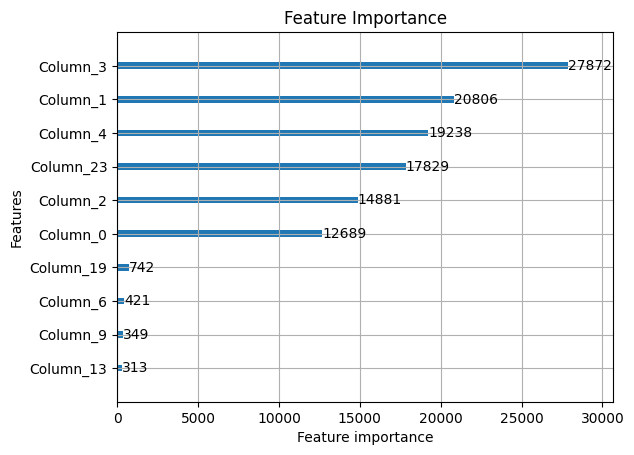

In [ ]:
#looking at feature importance of model
import matplotlib.pyplot as plt
import lightgbm as lgb

lgb.plot_importance(best_model, max_num_features=10)
plt.title("Feature Importance")
plt.show()

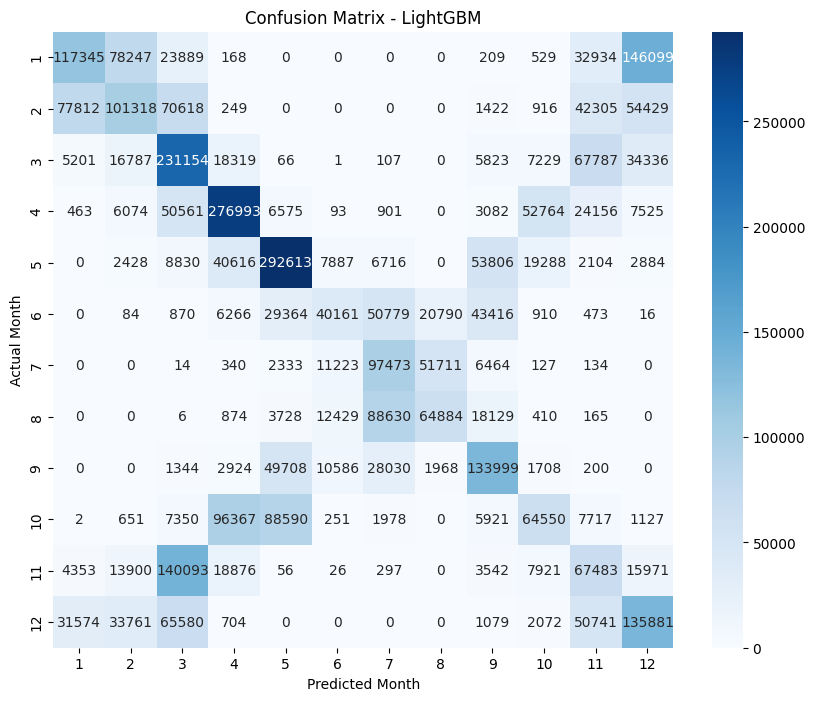

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_final_test, y_final_pred_stacking)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(1, 13), yticklabels=range(1, 13))
plt.xlabel("Predicted Month")
plt.ylabel("Actual Month")
plt.title("Confusion Matrix - LightGBM")
plt.show()

<ipython-input-24-9367852b3711>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


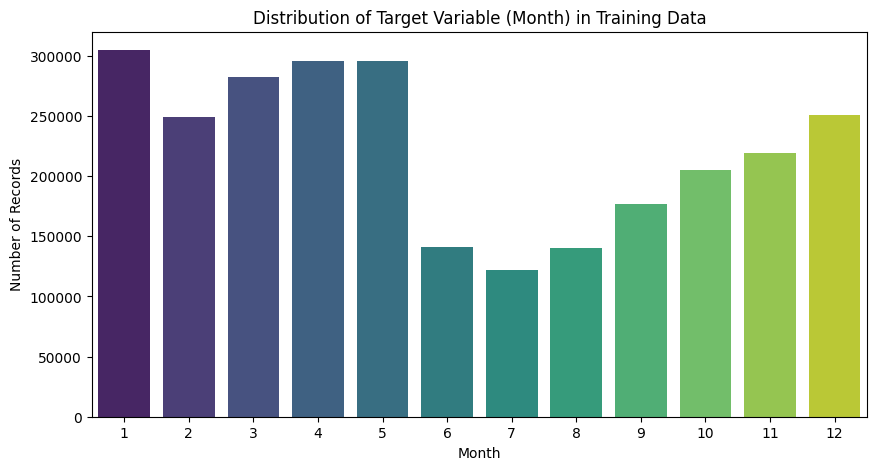

Most dominant class (month) in training data: 1


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences of each class in the training set
class_counts = y_train.value_counts().sort_index()

# Plot distribution of months
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xlabel("Month")
plt.ylabel("Number of Records")
plt.title("Distribution of Target Variable (Month) in Training Data")
plt.show()

# Get the most common month
most_dominant_month = class_counts.idxmax()
print(f"Most dominant class (month) in training data: {most_dominant_month}")

<ipython-input-25-b02625447d65>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pred_counts.index, y=pred_counts.values, palette="plasma")


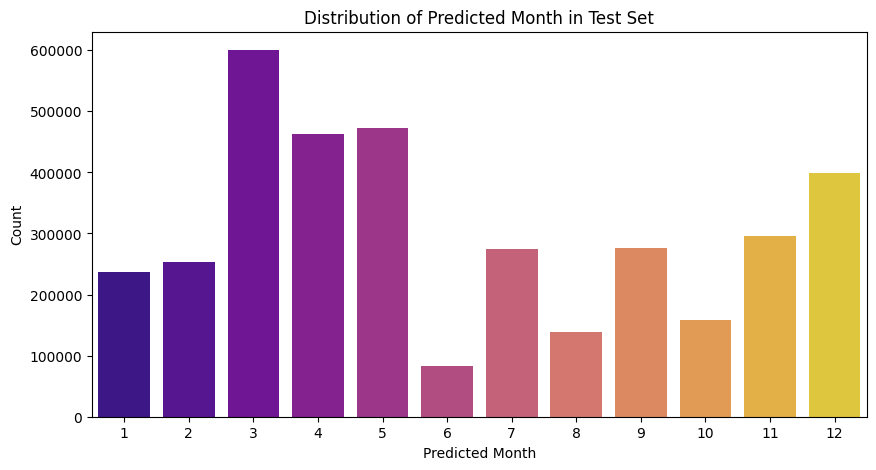

Most dominant predicted class (month): 3


In [ ]:
# Count occurrences in predicted labels
pred_counts = pd.Series(y_final_pred_stacking).value_counts().sort_index()

# Plot distribution of predictions
plt.figure(figsize=(10, 5))
sns.barplot(x=pred_counts.index, y=pred_counts.values, palette="plasma")
plt.xlabel("Predicted Month")
plt.ylabel("Count")
plt.title("Distribution of Predicted Month in Test Set")
plt.show()

# Get the most common predicted month
most_dominant_pred_month = pred_counts.idxmax()
print(f"Most dominant predicted class (month): {most_dominant_pred_month}")

<ipython-input-26-b7fda4bd06b1>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Month", y="Accuracy", data=error_df, palette="coolwarm")


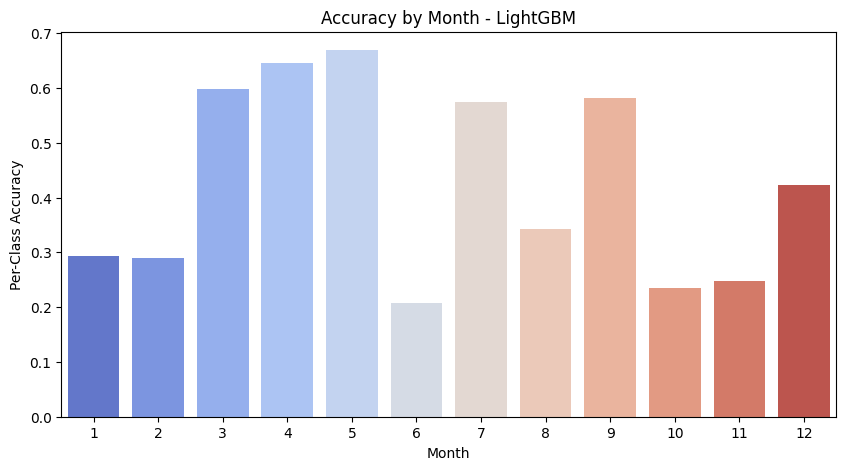

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_final_test, y_final_pred_stacking)

# Compute misclassification rates per class
errors_per_class = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

# Convert to DataFrame for visualization
error_df = pd.DataFrame({"Month": range(1, 13), "Accuracy": errors_per_class})
error_df.sort_values(by="Accuracy", ascending=True, inplace=True)

# Plot per-class error
plt.figure(figsize=(10, 5))
sns.barplot(x="Month", y="Accuracy", data=error_df, palette="coolwarm")
plt.ylabel("Per-Class Accuracy")
plt.xlabel("Month")
plt.title("Accuracy by Month - LightGBM")
plt.show()

In [ ]:
# **Check for Overlapping Observations Between Train & Test**
overlap_check = train_df.merge(final_test_df, on=["Latitude", "Longitude", "Observation_Date"], how="inner")

print(f"Number of location-date overlaps after fixing: {len(overlap_check)}")  # Should be 0

Number of location-date overlaps after fixing: 0


In [ ]:
print("Train Set Years:", train_df["Year"].min(), "to", train_df["Year"].max())
print("Test Set Years:", final_test_df["Year"].min(), "to", final_test_df["Year"].max())

Train Set Years: 1974 to 2020
Test Set Years: 2021 to 2024


In [ ]:
train_event_groups = set(train_df[["Latitude", "Longitude", "Observation_Date"]].apply(tuple, axis=1))
test_event_groups = set(final_test_df[["Latitude", "Longitude", "Observation_Date"]].apply(tuple, axis=1))

# Find intersection of event groups
overlapping_groups = train_event_groups & test_event_groups

print(f"Number of shared event groups between Train & Test: {len(overlapping_groups)}")  # Should be 0

Number of shared event groups between Train & Test: 0


In [ ]:
import pandas as pd
import lightgbm as lgb
import joblib

# Load trained LightGBM model
model_path = "/content/drive/MyDrive/best_lightgbm_classifier.pkl"
best_model = joblib.load(model_path)
print("Model loaded successfully!")

merged_df = pd.read_parquet('/content/drive/MyDrive/merged_bird_climate.parquet')

Model loaded successfully!


In [ ]:
merged_df.head()

,Latitude_x,Longitude_x,Observation_Date,Year,Month,Region,Land_Cover_Description,Has_Habitat_Change,Temp_celsius,Precip_mm,ClimatePeriod,Latitude_y,Longitude_y,SSP,Precipitation,Temp_Mean,Temp_Max,Temp_Min
0,19.3437,-96.4642,2017-10-01,2017,10,Mexico,Cropland/Natural Vegetation Mosaic,False,27.0,234.0,2011-2040,19.4124,-96.6626,ssp126,14.11,24.55,27.55,20.35
1,19.3437,-96.4642,2017-10-01,2017,10,Mexico,Cropland/Natural Vegetation Mosaic,False,27.0,234.0,2011-2040,19.4124,-96.6626,ssp370,13.64,24.65,27.65,20.55
2,19.3437,-96.4642,2017-10-01,2017,10,Mexico,Cropland/Natural Vegetation Mosaic,False,27.0,234.0,2011-2040,19.4124,-96.6626,ssp585,13.44,24.65,27.75,20.45
3,19.3437,-96.4642,2017-10-01,2017,10,Mexico,Cropland/Natural Vegetation Mosaic,False,27.0,234.0,2011-2040,19.4124,-96.6626,ssp126,14.11,24.55,27.55,20.35
4,19.3437,-96.4642,2017-10-01,2017,10,Mexico,Cropland/Natural Vegetation Mosaic,False,27.0,234.0,2011-2040,19.4124,-96.6626,ssp370,13.64,24.65,27.65,20.55


In [ ]:
# Drop historical temperature & precipitation fields (replace with future SSP-based projections)
merged_df.drop(columns=["Latitude_y", "Longitude_y", "Observation_Date"], errors="ignore", inplace=True)

In [ ]:
#rename Latitude_x and Longitude_x to Latitude and Longitude
merged_df = merged_df.rename(columns={'Latitude_x': 'Latitude', 'Longitude_x': 'Longitude'})

In [ ]:
##Replace Historical Climate Data with Future Projections**
## Make sure your future dataset has climate scenario-based columns like "Future_Temp_celsius"
if "Temp_Mean" in merged_df.columns and "Precipitation" in merged_df.columns:
    merged_df.rename(columns={'Temp_Mean': 'Temp_celsius', 'Precipitation': 'Precip_mm'}, inplace=True)
else:
    raise ValueError("Future climate projection data is missing. Ensure 'Temp_Mean' and 'Precipitation' exist.")

In [ ]:
# **1️⃣ Drop the Historical Climate Data (First Occurrence of Temp & Precip)**
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated(keep='last')]

In [ ]:
# Find the minimum year from TRAINING data to align the feature transformation
reference_year = 1974  # Replace with `train_df["Year"].min()` if needed
merged_df["year_relative"] = merged_df["Year"] - reference_year

In [ ]:
merged_df.head()

,Latitude,Longitude,Year,Month,Region,Land_Cover_Description,Has_Habitat_Change,ClimatePeriod,SSP,Precip_mm,Temp_celsius,Temp_Max,Temp_Min,year_relative
0,19.3437,-96.4642,2017,10,Mexico,Cropland/Natural Vegetation Mosaic,False,2011-2040,ssp126,14.11,24.55,27.55,20.35,43
1,19.3437,-96.4642,2017,10,Mexico,Cropland/Natural Vegetation Mosaic,False,2011-2040,ssp370,13.64,24.65,27.65,20.55,43
2,19.3437,-96.4642,2017,10,Mexico,Cropland/Natural Vegetation Mosaic,False,2011-2040,ssp585,13.44,24.65,27.75,20.45,43
3,19.3437,-96.4642,2017,10,Mexico,Cropland/Natural Vegetation Mosaic,False,2011-2040,ssp126,14.11,24.55,27.55,20.35,43
4,19.3437,-96.4642,2017,10,Mexico,Cropland/Natural Vegetation Mosaic,False,2011-2040,ssp370,13.64,24.65,27.65,20.55,43


In [ ]:
# Apply the same preprocessing as historical data
X_future_transformed = preprocessor.transform(merged_df)

In [ ]:
# Predict Migration Month for Each SSP Scenario
merged_df["Predicted_Month"] = best_model.predict(X_future_transformed)

# Save Predictions for Each SSP
merged_df.to_parquet("predicted_migration_future.parquet", index=False)
print("Future migration predictions saved.")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
Future migration predictions saved.
